# Spins and Leaps

Steve Taylor, Nov-2021

## Overview

This is a 2nd grader bit of homework, in which each player rolls dice, then spins a multiplier, to move their piece on a track, 100 squares long.

From the instructions, "... take turns rolling two dice to determine the number of small steps to take forward and spinning a spinner to leap forward by 10s."

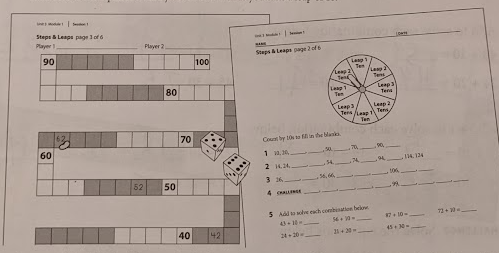

## Hypothesis

One doesn't have to play this many times with a seven year-old to realize that whoever starts first tends to win. But is that always true?

With nothing to back this "hunch", I propose that the player that starts first, wins.

### Setup and imports

In [1]:
%load_ext nb_black

import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import logging

logging.basicConfig(level=logging.ERROR)

from typing import Dict, List

# Prefect logs profusely. Bring the level to "error" to quiet things up a bit.
%env PREFECT__LOGGING__LEVEL=ERROR
from prefect import task, Flow, Parameter, unmapped
from prefect.executors import LocalExecutor, LocalDaskExecutor

env: PREFECT__LOGGING__LEVEL=ERROR


<IPython.core.display.Javascript object>

Create a function that rolls one or more N-sided dice.

In [2]:
def roll_dice(dice_count: int = 2, dice_sides: int = 6) -> (List, int):
    """
    Returns a tuple of the list of dice values, and the sum of the rolls
    """
    dice_values = []
    for i in range(dice_count):
        dice_values.append(random.randint(1, dice_sides))

    return dice_values, np.array(dice_values).sum()


# example roll
roll_dice()

([6, 4], 10)

<IPython.core.display.Javascript object>

The spinner is implemented with a single die, faces used for each section the spinner points to.

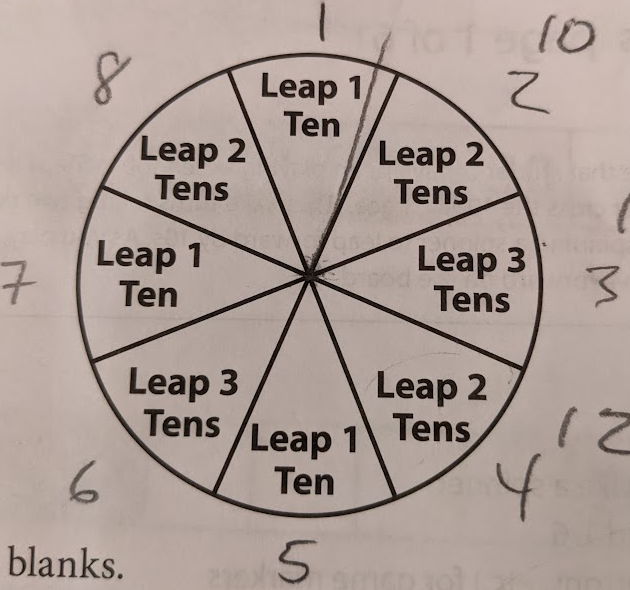

In [3]:
def spin_spinner() -> int:
    # This has weird landing pads:
    spinner_spaces = {1: 1, 2: 2, 3: 3, 4: 2, 5: 1, 6: 3, 7: 1, 8: 2}

    # reusing our roll_dice function above
    dice_vals, dice_sum = roll_dice(1, len(spinner_spaces))

    return spinner_spaces[dice_sum] * 10


# example spin
spin_spinner()

10

<IPython.core.display.Javascript object>

Create a utility function to initialize a game state object for keeping track of spaces, turns, and if a player has won.

In [4]:
def create_game_state(number_of_players: int) -> Dict:
    """
    Build up a dictionary to maintain the game state.
    Useful also for resetting the game.
    """

    # not necessary but interesting if we had a GUI
    colors = ["green", "red", "yellow", "blue"]

    game_state = {}
    for i in range(1, number_of_players + 1):
        game_state[i] = {
            "name": f"PLAYER {i}",
            "space": 0,
            "color": colors[i - 1 % len(colors)],
            "turns": 0,
            "winner": 0,
        }
    return game_state


# example state
create_game_state(4)

{1: {'name': 'PLAYER 1',
  'space': 0,
  'color': 'green',
  'turns': 0,
  'winner': 0},
 2: {'name': 'PLAYER 2', 'space': 0, 'color': 'red', 'turns': 0, 'winner': 0},
 3: {'name': 'PLAYER 3',
  'space': 0,
  'color': 'yellow',
  'turns': 0,
  'winner': 0},
 4: {'name': 'PLAYER 4', 'space': 0, 'color': 'blue', 'turns': 0, 'winner': 0}}

<IPython.core.display.Javascript object>

Make a simple game that takes a two dice roll, then adds a multiplier.

In [5]:
def simple_game(number_of_players: int = 4, game_spaces: int = 100) -> Dict:

    # create an initial game state dictionary
    game_state = create_game_state(number_of_players)

    # game loop
    while True:

        # for each player
        for player, v in game_state.items():

            v["turns"] += 1

            ###################
            # first roll the dice
            dice_vals, dice_sum = roll_dice()
            space_was = v["space"]
            space_is = v["space"] + dice_sum
            v["space"] = space_is

            # check to see if someone has won
            if space_is >= game_spaces:
                # winner!
                v["winner"] = 1
                return game_state

            ###################
            # second is the spinner
            spun_leap = spin_spinner()

            space_was = v["space"]
            space_is = v["space"] + spun_leap
            v["space"] = space_is

            # check to see if someone has won
            if space_is >= game_spaces:
                # winner!
                v["winner"] = 1
                return game_state


# example game
simple_game(number_of_players=4, game_spaces=100)

{1: {'name': 'PLAYER 1',
  'space': 103,
  'color': 'green',
  'turns': 5,
  'winner': 1},
 2: {'name': 'PLAYER 2', 'space': 73, 'color': 'red', 'turns': 4, 'winner': 0},
 3: {'name': 'PLAYER 3',
  'space': 96,
  'color': 'yellow',
  'turns': 4,
  'winner': 0},
 4: {'name': 'PLAYER 4',
  'space': 90,
  'color': 'blue',
  'turns': 4,
  'winner': 0}}

<IPython.core.display.Javascript object>

## Converting the game output to a dataframe

Run a sample game and convert the final game state into a dataframe.

In [6]:
winning_game_state = simple_game(number_of_players=4, game_spaces=100)
df = pd.DataFrame(winning_game_state)
df

,1,2,3,4
name,PLAYER 1,PLAYER 2,PLAYER 3,PLAYER 4
space,65,94,120,76
color,green,red,yellow,blue
turns,4,4,4,3
winner,0,0,1,0


<IPython.core.display.Javascript object>

Running many dataframes will work best if we transpose the columns and rows.

In [7]:
dft = df.T

# transpose is helpful but it wacks the numbers into objects
dft[["space", "turns", "winner"]] = dft[["space", "turns", "winner"]].apply(
    pd.to_numeric
)
dft.dtypes

name      object
space      int64
color     object
turns      int64
winner     int64
dtype: object

<IPython.core.display.Javascript object>

The player number is now the index. Make this a column.

In [8]:
dft["player_number"] = dft.index
dft.insert(0, "game_number", 1)
dft

,game_number,name,space,color,turns,winner,player_number
1,1,PLAYER 1,65,green,4,0,1
2,1,PLAYER 2,94,red,4,0,2
3,1,PLAYER 3,120,yellow,4,1,3
4,1,PLAYER 4,76,blue,3,0,4


<IPython.core.display.Javascript object>

## Create a reusable flow to run the game N number of times

We have some choices here. The most obvious choice is to wrap the the above steps into a function and run that function in a `for` loop. Instead, I use a package called `prefect` to break the pieces into tasks, and then create a flow from those tasks. The advantage is the flow can be executed using a multi-threaded or -scheduler, which greatly decreases the execution time of the notebook.

In [9]:
@task
def play_game(
    game_number: int, number_of_players: int, game_spaces: int
) -> pd.DataFrame:
    """
    Play a game with a number of players, for a set number of spaces.
    The game number is included in the returned dataframe.
    """
    winning_game_state = simple_game(
        number_of_players=number_of_players, game_spaces=game_spaces
    )
    df = pd.DataFrame(winning_game_state).T
    df[["space", "turns", "winner"]] = df[["space", "turns", "winner"]].apply(
        pd.to_numeric
    )
    df["player_number"] = df.index
    df.insert(0, "game_number", game_number)
    return df


@task
def reduce(df_list: List) -> pd.DataFrame:
    """
    Concatonate all of the dataframes in the df_list into one.
    Return that final dataframe.
    """
    df = pd.DataFrame()
    for dft in df_list:
        df = pd.concat([df, dft], ignore_index=True)
    return df


@task
def create_map(number_of_items: int) -> List:
    # create a list for the map function to use later
    map_list = []
    for i in range(number_of_items):
        map_list.append(i)
    return map_list

<IPython.core.display.Javascript object>

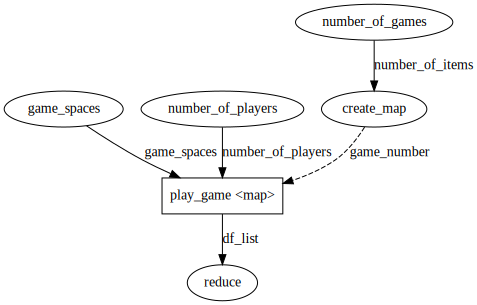

<IPython.core.display.Javascript object>

In [10]:
# Using a local dask executor gives us the ability to run Python processes in parallel.
executor = LocalDaskExecutor(scheduler="processes")

# configure the flow, which isn't the same as running it.
with Flow("Map Reduce", executor=executor) as flow:
    number_of_games = Parameter("number_of_games")()
    number_of_players = Parameter("number_of_players", default=4)()
    game_spaces = Parameter("game_spaces", default=100)()

    map_list = create_map(number_of_games)

    mapped_result = play_game.map(
        map_list, unmapped(number_of_players), unmapped(game_spaces)
    )

    reduced_result = reduce(mapped_result)

# This requires the graphviz binary in path on your machine.
# Comment it out, if you don't have or need that.
flow.visualize()

## A four player game

Run a four player game many times and create a final dataframe.

In [11]:
# Run the flow, given some parameters, and return the final flow state.
state = flow.run(
    parameters={"number_of_games": 1000, "number_of_players": 4, "game_spaces": 100},
)

# grab the final task result. It's our final dataframe.
df = state.result[reduced_result].result
df.head()

,game_number,name,space,color,turns,winner,player_number
0,0,PLAYER 1,86,green,3,0,1
1,0,PLAYER 2,74,red,3,0,2
2,0,PLAYER 3,90,yellow,3,0,3
3,0,PLAYER 4,104,blue,3,1,4
4,1,PLAYER 1,92,green,4,0,1


<IPython.core.display.Javascript object>

In [12]:
df.dtypes

game_number       int64
name             object
space             int64
color            object
turns             int64
winner            int64
player_number     int64
dtype: object

<IPython.core.display.Javascript object>

It's always worth checking to see how columns are correlated.

In [13]:
corr = round(df.corr(), 2)
corr

,game_number,space,turns,winner,player_number
game_number,1.00,0.00,0.01,0.00,-0.00
space,0.00,1.00,0.71,0.72,-0.41
turns,0.01,0.71,1.00,0.51,-0.53
winner,0.00,0.72,0.51,1.00,-0.37
player_number,-0.00,-0.41,-0.53,-0.37,1.00


<IPython.core.display.Javascript object>

Nice to see it in a heatmap. Here using Panda's built-in matplotlib.

In [14]:
corr.style.background_gradient(cmap="coolwarm").format(precision=2)

,game_number,space,turns,winner,player_number
game_number,1.00,0.00,0.01,0.00,-0.00
space,0.00,1.00,0.71,0.72,-0.41
turns,0.01,0.71,1.00,0.51,-0.53
winner,0.00,0.72,0.51,1.00,-0.37
player_number,-0.00,-0.41,-0.53,-0.37,1.00


<IPython.core.display.Javascript object>

And here using seaborn.

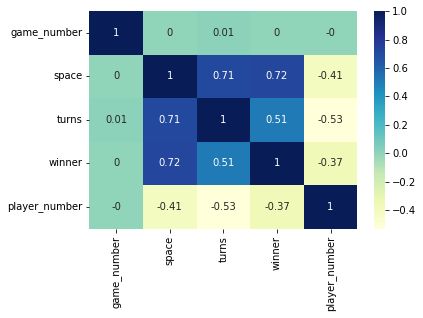

<IPython.core.display.Javascript object>

In [15]:
ax = sns.heatmap(
    corr,
    annot=True,
    cmap="YlGnBu",
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
)

Verify that there are two players, and note the distribution of wins.

In [16]:
df[["player_number"]].where(df.winner == 1).dropna().value_counts()

player_number
1.0              529
2.0              246
3.0              134
4.0               91
dtype: int64

<IPython.core.display.Javascript object>

Same information but plotted.

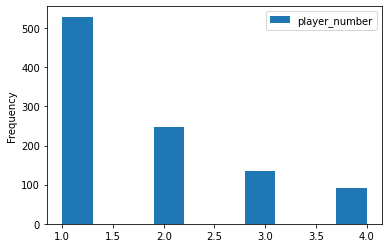

<IPython.core.display.Javascript object>

In [17]:
ax = df[["player_number"]].where(df.winner == 1).dropna().plot.hist()

## A two player game

Run a two player game many times and create a final dataframe.

In [18]:
state = flow.run(
    parameters={"number_of_games": 1000, "number_of_players": 2, "game_spaces": 100},
)
df = state.result[reduced_result].result

<IPython.core.display.Javascript object>

Verify that there are two players, and note the distribution of wins.

In [19]:
df[["player_number"]].where(df.winner == 1).dropna().value_counts()

player_number
1.0              701
2.0              299
dtype: int64

<IPython.core.display.Javascript object>

Same information but plotted.

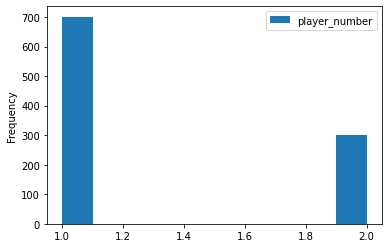

<IPython.core.display.Javascript object>

In [20]:
ax = df[["player_number"]].where(df.winner == 1).dropna().plot.hist()

## Conclusion

My assertion was that the player that starts first always wins. This isn't true. However, the first player _almost_ always wins, in most cases twice as likely as any other player. If I modify the hypothesis to assert that it is always best to be the first player, then my hypothesis would hold.

One follow-on idea is to increase the board space count. The following shows that at some point where the game space are **greatly** increased, then all players start to have an even chance of winning.

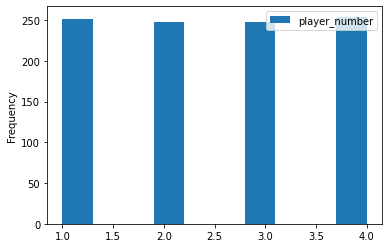

<IPython.core.display.Javascript object>

In [21]:
state = flow.run(
    parameters={"number_of_games": 1000, "number_of_players": 4, "game_spaces": 10000},
)
df = state.result[reduced_result].result
ax = df[["player_number"]].where(df.winner == 1).dropna().plot.hist()